In [1]:
#import libs and tools
import warnings
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import seaborn as sns
from pandas import datetime
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [25]:
color = sns.color_palette()
print('Please wait. Importing data...')
df_lfu = pd.read_excel('C:/Users/ThinkPad/Desktop/models/PM10_2020_05.xls',header=0,encoding='utf-8')

df_fzi = pd.read_csv('c:/Users/ThinkPad/Desktop/rohdaten_v4.csv',float_precision='utf-8')

print('import completed.')
df_fzi['timestamp'] = pd.to_datetime(df_fzi['timestamp'])
df_fzi = df_fzi.set_index('timestamp')
df_fzi= df_fzi[['pm10']]
df_fzi=df_fzi.resample('60min').mean()


#def date_parser(x):
#    return datetime.strptime(x, "%d.%m.%Y %H:%M")
df_lfu[['date','time']] = df_lfu['Zeitpunkt'].str.split(expand=True)
df_lfu['datetime'] = (pd.to_datetime(df_lfu.pop('date'), format='%d.%m.%Y') + 
                  pd.to_timedelta(df_lfu.pop('time') + ':00'))
df_lfu = df_lfu.set_index('datetime') 
print (df_lfu,df_fzi)





Please wait. Importing data...
import completed.
                            Zeitpunkt  Andechs/Rothenfeld  \
datetime                                                    
2020-05-01 01:00:00  01.05.2020 01:00                   4   
2020-05-01 02:00:00  01.05.2020 02:00                   4   
2020-05-01 03:00:00  01.05.2020 03:00                   3   
2020-05-01 04:00:00  01.05.2020 04:00                   3   
2020-05-01 05:00:00  01.05.2020 05:00                   3   
...                               ...                 ...   
2020-05-31 20:00:00  31.05.2020 20:00                  15   
2020-05-31 21:00:00  31.05.2020 21:00                  14   
2020-05-31 22:00:00  31.05.2020 22:00                  13   
2020-05-31 23:00:00  31.05.2020 23:00                  12   
2020-06-01 00:00:00  31.05.2020 24:00                  11   

                     Ansbach/Residenzstraße  Augsburg/Bourges-Platz  \
datetime                                                              
2020-05-01 01:0

In [30]:
df_fzi=df_fzi['2020-05-11 01:00:00':'2020-05-17']


In [31]:
df=df_fzi
df['lfu']=df_lfu['Augsburg/Königsplatz']
df['fzi']=df_fzi['pm10']

print(df)

                          pm10 lfu        fzi
timestamp                                    
2020-05-11 01:00:00   9.785675   9   9.785675
2020-05-11 02:00:00   8.170562   8   8.170562
2020-05-11 03:00:00   8.466080  14   8.466080
2020-05-11 04:00:00  14.749472  16  14.749472
2020-05-11 05:00:00  17.414069  21  17.414069
...                        ...  ..        ...
2020-05-17 19:00:00   6.608402  10   6.608402
2020-05-17 20:00:00   9.287926  11   9.287926
2020-05-17 21:00:00   7.633697  13   7.633697
2020-05-17 22:00:00   8.144517  16   8.144517
2020-05-17 23:00:00  12.191944  14  12.191944

[167 rows x 3 columns]


In [32]:
df=df.fillna(method='pad')

In [33]:
import numpy as np
lfu=df.lfu.values
fzi=df.fzi.values
a=len(fzi)
b=np.ones(a)
c = np.row_stack((fzi,b))
ATA = np.dot(c,c.T).astype(float) 
ATb = np.dot(c,lfu.T).astype(float)
res = np.linalg.solve(ATA, ATb)
print(res)

[0.7159883  5.80330149]


In [34]:
cali=res[0]*fzi+res[1]
print(cali)

[12.8097307  11.65332844 11.86491569 16.36375129 18.27157134 17.48101454
 17.15613949 18.23680904 19.47458862 19.87755399 18.75746905 16.41022013
 16.16418071 15.46388389 12.12694882  8.1064217   8.0291535   6.8021043
  7.91682518  7.02180731  7.99190613  7.82162985  8.46813072  8.55434224
  9.92910772 10.2755389  12.14795941 11.58425177 11.3249132  11.63300391
 11.63300391 11.63300391 11.63300391  9.43255372  7.15788084  8.40548096
  8.54889157  7.74941582  8.81717567  8.99332995  9.10087533  8.80007537
  9.16254916  9.42469014  8.82937576  9.23928915  9.24100537  9.54714877
  9.79131816  9.74846226 11.49852658 10.84894983 11.94009555 13.55046726
 13.85064786 10.51977603 11.34190187 10.16648058 10.22700929 12.15166794
 14.46857864 13.05525759 11.81317808 16.0518076  18.63006466 16.8167355
 14.43792414 13.01770161 13.45043098 17.01826962 23.36009342 21.74453141
 16.78667081 20.23118121 20.14050129 12.61452192 12.4163499  14.98751658
 11.44292305 11.04412757 14.19444999 14.53552916 14.6

In [35]:
from pandas import DataFrame
df["cali"] = DataFrame(cali,index=df.index)

The Mean Squared Error of fzi is 46.47
The Mean Squared Error of calibration is 34.22


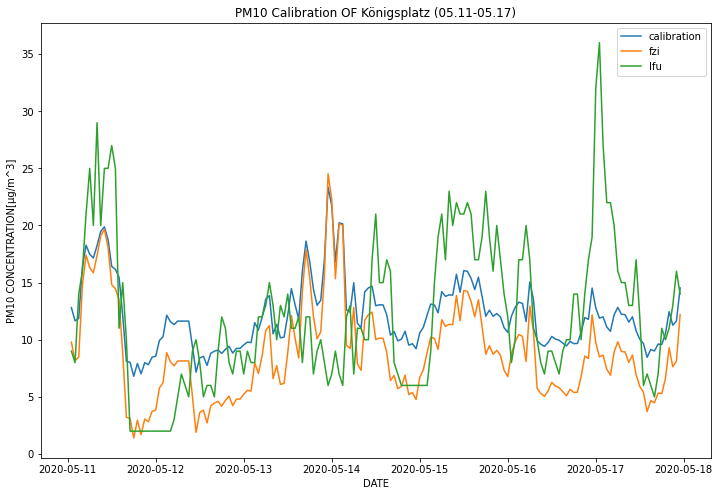

In [37]:
fig = plt.figure(figsize=(12,8))
plt.plot(df["cali"],label="calibration")
plt.plot(df['fzi'],label="fzi")
plt.plot(df['lfu'],label="lfu")
plt.xlabel("DATE")
plt.ylabel("PM10 CONCENTRATION[μg/m^3]")
plt.title("PM10 Calibration OF Königsplatz (05.11-05.17)")
plt.legend()
pm10_fzi=df['fzi']
pm10_cali=df["cali"]
pm10_truth = df['lfu']
rmse_fzi = ((pm10_fzi- pm10_truth) ** 2).mean()
rmse_cali = ((pm10_cali- pm10_truth) ** 2).mean()
print('The Mean Squared Error of fzi is {}'.format(round(rmse_fzi, 2)))
print('The Mean Squared Error of calibration is {}'.format(round(rmse_cali, 2)))


